# Reading the data

In [1]:
# basic imports
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

dataPath = "../data/"

In [2]:
# reading CSV file
reader = csv.reader(open(dataPath + 'features_2.csv', 'r'), delimiter=',')
data_full = np.array(list(reader))
reader = csv.reader(open(dataPath + 'all_endpoints_with_missing_values_012615.csv', 'r'), delimiter=',')
activity_full = np.array(list(reader))

In [3]:
# feature names
feature_names = data_full[0, 1:]

# names of the proteins
protein_names = data_full[1:, 0]
protein_names1 = activity_full[1:, 0]
print 'Protein names equality check:', np.array_equal(protein_names1, protein_names)

# names of receptors
receptor_names = activity_full[0, 1:]

# Object-Feature matrix (proteins description)
X = data_full[1:, 1:].astype('double')

# Activity matrix
Y = activity_full[1:, 1:].astype('int16')

# Removing constant features
ind = np.var(X, axis = 0) != 0
X = X[:, ind]
feature_names = feature_names[ind]

# Number of features
N = X.shape[1]

Protein names equality check: True


In [4]:
print receptor_names

['NR-AhR' 'NR-AR-LBD' 'NR-AR' 'SR-MMP' 'NR-ER' 'SR-HSE' 'SR-p53'
 'NR-PPAR-gamma' 'SR-ARE' 'NR-Aromatase' 'SR-ATAD5' 'NR-ER-LBD']


# Training classifiers and printing results

In [5]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold as SKF

In [6]:
def getXY(classToTrain, X, Y, badValue = 999):
    """
    Get objects and answers for class classToTrain
    for which answers are available
    """
    
    haveAnswersObjectsIndices = np.where(Y[:, classToTrain] != badValue)
    classX = X[haveAnswersObjectsIndices, :][0]
    classY = Y[haveAnswersObjectsIndices, classToTrain][0]
    return classX, classY

In [257]:
def showROCCurve(fpr, tpr, auc_mean, auc_std, filename):
    """
    Plot a ROC curve from fpr, tpr
    """
    
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    params = {'text.usetex' : True,
          'font.size' : 15,
#          'font.family' : 'lmodern',
          'text.latex.unicode': True}
    plt.rcParams.update(params) 
    plt.plot(fpr, tpr, label = None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR', fontsize=15)
    plt.ylabel('TPR', fontsize=15)
    plt.tick_params(axis='both', which='major')
    auc_mean = '%.2g' % auc_mean
    auc_std = '%.1g' % auc_std
    plt.title(r"AUC $= %s\,\pm\,%s$" % (auc_mean, auc_std), fontsize=15)
    if filename != None:
        plt.savefig(filename + ".eps", bbox_inches = 'tight')
    plt.show()

In [8]:
def getROCCurve(XTrain, XTest, YTrain, YTest):
    """
    Train classifier and return fpr, tpr
    """
    
    # Learn to predict the class
    classifier = LR()
    classifier.fit(XTrain, YTrain)

    # get predicted probabilities for class
    YScore = classifier.predict_proba(XTest)[:, 1]

    # calculate fpr and tpr
    fpr, tpr, _ = roc_curve(YTest, YScore)
    return(fpr, tpr)

In [9]:
def showClass(currentClass, X, Y, folds):
    """
    Split data, train classifiers, get AUC Array, show chart
    """
    # get objects and answers with existing answers
    XClass, YClass = getXY(currentClass, X, Y)

    # get folds-fold cross validation split indices
    IFolds = SKF(YClass, folds)
    
    roc_auc = list()
    for ITrain, ITest in IFolds:
        # get train & test data
        XTrain, YTrain = XClass[ITrain], YClass[ITrain]
        XTest,  YTest  = XClass[ITest],  YClass[ITest]
        
        # train classifier
        # get FPR, TPR
        fpr, tpr = getROCCurve(XTrain, XTest, YTrain, YTest)
        
        # get AUC value
        roc_auc.append(auc(fpr, tpr))
        
    showROCCurve(fpr, tpr, np.mean(roc_auc), np.std(roc_auc), "class%d" % (currentClass + 1))

In [ ]:
folds = 5
for currentClass in range(Y.shape[1]):
    showClass(currentClass, X, Y, folds)

In [ ]:
def printClassStatistics(currentClass, X, Y):
    ans_1 = len(np.where(Y[:, currentClass] == 1)[0])
    ans_0 = len(np.where(Y[:, currentClass] == 0)[0])
    ans_none = len(np.where(Y[:, currentClass] == 999)[0])
    total = Y.shape[0]
    
    #print("Class %d TOTAL=%d ONES=%d (%.2g %%) ZEROS=%d (%.2g %%) KNOWN=%d (%.2g %%)" % (currentClass + 1,
    #                                                                                     total, ans_1, 100. * ans_1 / total,
    #                                                                                     ans_0, 100. * ans_0 / total,
    #                                                                                     ans_0 + ans_1,
    #                                                                                     100. * (ans_0 + ans_1) / total))
    texStr="{\\tt %s}\n& $\mathbf{%d}\, (%d \%%)$\n& $\mathbf{%d}\, (%d \%%)$\n& $\mathbf{%d}\, (%d \%%)$\\\\\n"
    print(texStr % (receptor_names[currentClass], ans_none, 100 * ans_none / total,
                    ans_0, 100 * ans_0 / total,
                   ans_1, 100 * ans_1 / total))

In [10]:
for currentClass in range(Y.shape[1]):
    printClassStatistics(currentClass, X, Y)

NameError: name 'printClassStatistics' is not defined

In [11]:
Xc, Yc = getXY(0, X, Y)

In [12]:
classifier = LR(fit_intercept = False)
classifier.fit(Xc, Yc)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
classifier.intercept_ = 0
classifier.predict_proba(Xc)[0]

array([ 0.99744249,  0.00255751])

In [34]:
classifier.intercept_ = 5
classifier.predict_proba(Xc)[0]

array([ 0.7243533,  0.2756467])

In [ ]:
classifier.intercept_=-100
# get predicted probabilities for class
YScore = classifier.decision_function(Xc)
# calculate fpr and tpr

In [ ]:
fpr, tpr, _ = roc_curve(Yc, YScore)

In [168]:
Ys=np.argsort(YScore)[::-1]

In [171]:
Ys.shape[0]

5100

In [247]:
fpr0=0
tpr0=0
for i in range(Ys.shape[0]):
    ansr = Yc[Ys[i]]
    if ansr == 0:
        fpr0 += 1
        print i, Ys[i], 100.*fpr0/N, 100.*tpr0/P
    if ansr == 1:
        tpr0 += 1
        print i, Ys[i], 100.*fpr0/N, 100.*tpr0/P
        
    if 1. * fpr0 / N >= 0.2:
        print i, Ys[i]
        break

0 1237 0.0 0.167504187605
1 1606 0.0 0.335008375209
2 2693 0.0 0.502512562814
3 4675 0.0 0.670016750419
4 670 0.0 0.837520938023
5 5050 0.0 1.00502512563
6 4877 0.0 1.17252931323
7 1010 0.0 1.34003350084
8 3972 0.0 1.50753768844
9 5072 0.0 1.67504187605
10 3709 0.0 1.84254606365
11 4534 0.0 2.01005025126
12 118 0.0 2.17755443886
13 1065 0.0 2.34505862647
14 168 0.0 2.51256281407
15 268 0.0222074172774 2.51256281407
16 2321 0.0222074172774 2.68006700168
17 1433 0.0222074172774 2.84757118928
18 4467 0.0222074172774 3.01507537688
19 4632 0.0444148345547 3.01507537688
20 1842 0.0444148345547 3.18257956449
21 1403 0.0444148345547 3.35008375209
22 3277 0.0444148345547 3.5175879397
23 4843 0.0666222518321 3.5175879397
24 5015 0.0888296691095 3.5175879397
25 1914 0.0888296691095 3.6850921273
26 4767 0.0888296691095 3.85259631491
27 5026 0.0888296691095 4.02010050251
28 4909 0.0888296691095 4.18760469012
29 3475 0.0888296691095 4.35510887772
30 349 0.0888296691095 4.52261306533
31 363 0.0888296

(625,)

In [145]:
classifier.intercept_=100
# get predicted probabilities for class
YScore = classifier.decision_function(Xc)
# calculate fpr and tpr
fpr1, tpr1, _ = roc_curve(Yc, YScore, pos_label=1)

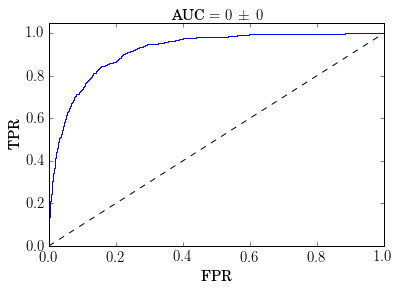

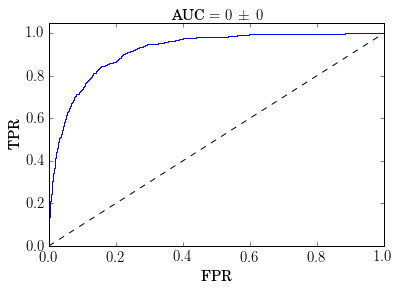

In [146]:
showROCCurve(fpr, tpr, 0, 0, "")
showROCCurve(fpr1, tpr1, 0, 0, "")

In [260]:
def getIndexByFPR(classifier, Xc, Yc, fprLow):
    YScore = classifier.decision_function(Xc)
    Ys=np.argsort(YScore)[::-1]
    fpr0=0
    tpr0=0
    for i in range(Ys.shape[0]):
        ansr = Yc[Ys[i]]
        if ansr == 0:
            fpr0 += 1
            #print i, Ys[i], 100.*fpr0/N, 100.*tpr0/P
        if ansr == 1:
            tpr0 += 1
            #print i, Ys[i], 100.*fpr0/N, 100.*tpr0/P
            
        if 1. * fpr0 / N >= fprLow:
            return(Ys[i])

In [259]:
def setClassifierObject(classifier, Xc, index):
    classifier.intercept_ = 0
    classifier.intercept_ = -classifier.decision_function([Xc[index]])

In [212]:
np.argsort(YScore)[::-1][223]

677

In [131]:
tpr[482]

0.8693467336683417

In [132]:
obj_ind=np.where(fpr>=0.2)[0][0]
#np.argsort(YScore)[482]

In [97]:
np.where(fpr>=0.2)[0]

array([482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507,
       508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520,
       521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
       534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546,
       547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559,
       560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572,
       573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598,
       599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611,
       612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624])

In [ ]:
fpr[482]
np.argsort(YScore)[::-1]

In [152]:
len(tpr)


625

In [151]:
fpr

array([  0.00000000e+00,   0.00000000e+00,   2.22074173e-04,
         2.22074173e-04,   4.44148346e-04,   4.44148346e-04,
         8.88296691e-04,   8.88296691e-04,   1.11037086e-03,
         1.11037086e-03,   1.33244504e-03,   1.33244504e-03,
         1.77659338e-03,   1.77659338e-03,   1.99866755e-03,
         1.99866755e-03,   2.22074173e-03,   2.22074173e-03,
         2.44281590e-03,   2.44281590e-03,   2.66489007e-03,
         2.66489007e-03,   2.88696425e-03,   2.88696425e-03,
         3.10903842e-03,   3.10903842e-03,   3.33111259e-03,
         3.33111259e-03,   3.55318676e-03,   3.55318676e-03,
         3.77526094e-03,   3.77526094e-03,   4.21940928e-03,
         4.21940928e-03,   5.10770597e-03,   5.10770597e-03,
         5.32978015e-03,   5.32978015e-03,   5.77392849e-03,
         5.77392849e-03,   6.44015101e-03,   6.44015101e-03,
         6.88429936e-03,   6.88429936e-03,   7.10637353e-03,
         7.10637353e-03,   8.21674439e-03,   8.21674439e-03,
         8.88296691e-03,

In [249]:
#for i in range(Yc.shape[0]):
#    print i, FPRTPRByID(i)
    
#1936
FPRTPRByID(1936)

(0.19986675549633579, 0.8693467336683417)

In [238]:
#np.where(fpr>=0.2)[0]
classifier.intercept_=0
classifier.decision_function([Xc[677]])

array([ 0.55923344])

In [228]:
classifier.intercept_=-w0

In [229]:
P=len(np.where(Yc==1)[0])

In [230]:
N=len(np.where(Yc==0)[0])

In [231]:
N

4503

In [232]:
P

597

In [233]:
TP=len(np.where((classifier.predict(Xc)==1)&(Yc==1))[0])
FP=len(np.where((classifier.predict(Xc)==1)&(Yc==0))[0])

In [236]:
print 1.*TP/P
print 1.*FP/N

0.298157453936
0.00999333777482


In [224]:
Yc==1

array([False,  True, False, ..., False, False,  True], dtype=bool)

In [226]:
classifier.predict(Xc)==1

array([False, False, False, ..., False, False,  True], dtype=bool)

In [268]:
def FPRTPR(classifier, Xc, Yc):
    N=len(np.where(Yc==0)[0])
    P=len(np.where(Yc==1)[0])
    TP=len(np.where((classifier.predict(Xc) == 1) & (Yc==1))[0])
    FP=len(np.where((classifier.predict(Xc) == 1) & (Yc==0))[0])
    fpr_ = 1. * FP / N
    tpr_ = 1. * TP / P
    return fpr_, tpr_

array([0, 0, 0, ..., 0, 0, 1], dtype=int16)

In [252]:
Yc

array([0, 1, 0, ..., 0, 0, 1], dtype=int16)

In [253]:
C=list()
C.append(LR(fit_intercept=False))

In [254]:
X0, Y0 = getXY(0, X, Y)
C[0].fit(X0, Y0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

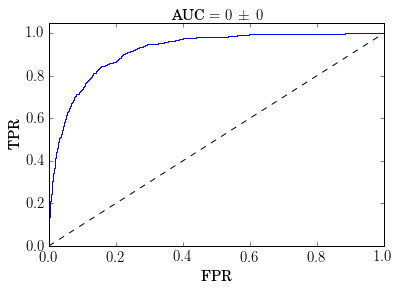

In [266]:
fpr, tpr, _ = roc_curve(Y0, C[0].decision_function(X0))
showROCCurve(fpr, tpr, 0, 0, None)

In [267]:
getIndexByFPR(C[0], X0, Y0, 0.25)

2635

In [269]:
setClassifierObject(C[0], X0, 2635)

In [270]:
FPRTPR(C[0], X0, Y0)

(0.2498334443704197, 0.9179229480737019)

In [273]:
ind2 = np.where(Y[:, 1] != 999)[0]

In [306]:
Y10=np.copy(Y[ind2])[:, 0:1]
#for i in range()
#Y1[ind2, 0]

In [307]:
for i in range(Y1.shape[0]):
    if Y10[i, 0] == 999:
        Y10[i, 0] = C[0].predict([X[ind2[i]]])

In [308]:
Y1=Y[ind2,1]

In [313]:
Y10.T

array([[0, 0, 1, ..., 1, 1, 0]], dtype=int16)

In [318]:
X1=np.concatenate((X[ind2], Y10), axis=1)

In [322]:
X1[:,165]

array([ 0.,  0.,  1., ...,  1.,  1.,  0.])

In [323]:
Y10

array([[0],
       [0],
       [1],
       ..., 
       [1],
       [1],
       [0]], dtype=int16)

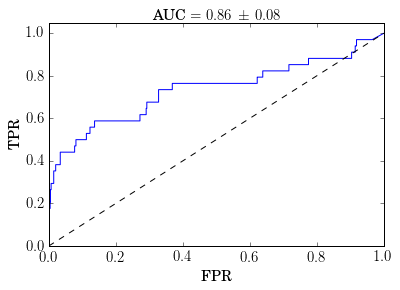

In [333]:
showClass(0, X1, np.array([Y1]).T, 5)

In [332]:
np.array([Y1]).T

array([[0],
       [0],
       [0],
       ..., 
       [0],
       [0],
       [0]], dtype=int16)